### Imports

In [2]:
pip install librosa

  Using cached librosa-0.11.0-py3-none-any.whl.metadata (8.7 kB)
  Using cached audioread-3.0.1-py3-none-any.whl.metadata (8.4 kB)
  Using cached soundfile-0.13.1-py2.py3-none-macosx_10_9_x86_64.whl.metadata (16 kB)
  Using cached pooch-1.8.2-py3-none-any.whl.metadata (10 kB)
  Using cached lazy_loader-0.4-py3-none-any.whl.metadata (7.6 kB)
Using cached librosa-0.11.0-py3-none-any.whl (260 kB)
Using cached audioread-3.0.1-py3-none-any.whl (23 kB)
Using cached lazy_loader-0.4-py3-none-any.whl (12 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 10.3 MB/s  0:00:001.3 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.0/43.0 MB 18.5 MB/s  0:00:02 18.9 MB/s eta 0:00:01
Using cached pooch-1.8.2-py3-none-any.whl (64 kB)
Using cached soundfile-0.13.1-py2.py3-none-macosx_10_9_x86_64.whl (1.1 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9/9 [librosa]5;237m━━━━ 8/9 [librosa]]
Note: you may need to restart the kernel to use updated packages.


In [9]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
import glob 

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

In [18]:
# Base directory
base_dir = "./archive"

# Lists to store file paths and the third number in the filename
file_paths = []
emotions = []

emotions_dict ={
    "01" : "neutral",
    "02" : "calm",
    "03" : "happy",
    "04" : "sad",
    "05" : "angry",
    "06" : "fear",
    "07" : "disgust",
    "08" : "suprised"
}

# Loop over all Actor_XX folders
for actor_folder in sorted(glob.glob(os.path.join(base_dir, "Actor_*"))):
    # Get all .wav files in this folder
    wav_files = glob.glob(os.path.join(actor_folder, "*.wav"))
    
    for wav_file in wav_files:
        # Append full path to the list
        file_paths.append(wav_file)
        
        # Extract filename (without folder)
        filename = os.path.basename(wav_file)
        
        # Split by '-' and get the third number
        parts = filename.split('-')
        if len(parts) >= 3:
            emotion_number = parts[2]
            emotions.append(emotions_dict[emotion_number])
        else:
            print(f"Warning: unexpected filename format: {filename}")

# Check if both lists are equal in length
print(f"Collected {len(file_paths)} files.")
print(f"Collected {len(emotions)} labels.")
print("Example:", file_paths[200], "->", emotions[200])

Collected 1440 files.
Collected 1440 labels.
Example: ./archive/Actor_04/03-01-07-01-02-02-04.wav -> disgust


### Ploting Functions

In [5]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

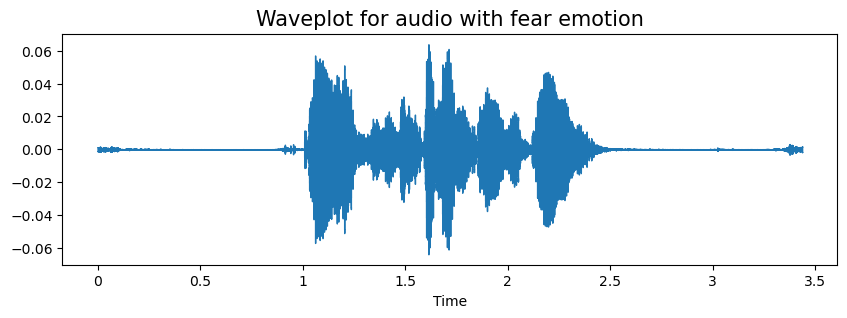

In [29]:
path = "./archive/Actor_01/03-01-06-01-02-01-01.wav"

data, sampling_rate = librosa.load(path)

create_waveplot(data, sampling_rate, 'fear')

Audio(path)

### Augmentation 

In [33]:
def noise(data):
    noise_amp = 0.050*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)    

### Extract Melspectogram Features

In [36]:
def extract_melspectogram_features(data, sampling_rate):
    result = np.array([])
    
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sampling_rate).T, axis=0)
    result = np.hstack((result, mel))
    return result

def get_features(path):
    data, sampling_rate = librosa.load(path, duration=3, offset=0.5)

    # Appending with no augmentation
    no_augmentation_features = extract_melspectogram_features(data, sampling_rate) # We added sampling_rate arguemnt on our own 
    result = np.array(no_augmentation_features)

    # Stacking pitch augmentation
    with_pitch_features = pitch(data, sampling_rate)
    result_with_pitch = extract_melspectogram_features(with_pitch_features, sampling_rate)
    result = np.vstack((result, result_with_pitch))

    # Stacking noise augmentation
    with_noise_features = noise(data)
    result_with_noise = extract_melspectogram_features(with_noise_features, sampling_rate)
    result = np.vstack((result, result_with_noise))

    return result

In [37]:
audio_files_features, corresponding_emotions = [], []

for path, emotion in zip(file_paths, emotions):
    feature = get_features(path)
    for audio_file in feature:
        audio_files_features.append(audio_file)
        corresponding_emotions.append(emotion)

print(len(audio_files_features))
print(len(corresponding_emotions))

4320
4320
